## Image processing (Dragonfly as example)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology
from skimage.restoration import denoise_bilateral
from skimage.filters import threshold_local
from skimage.morphology import skeletonize

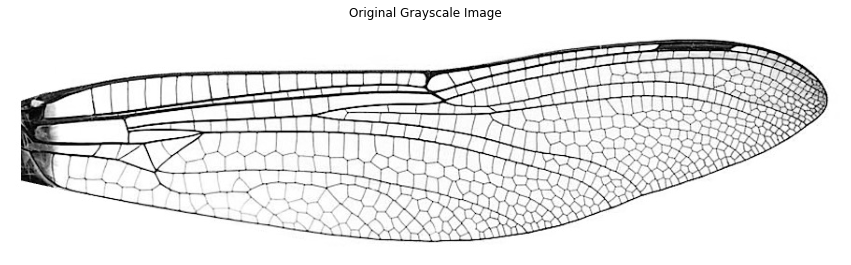

In [2]:
# Load grayscale image
img = io.imread('wing1.jpg', as_gray=True)

# Plot
plt.figure(figsize=(15, 10))
plt.imshow(img, cmap='gray')  # Use grayscale colormap
plt.title("Original Grayscale Image")
plt.axis('off')  # Hide axis ticks
plt.show()

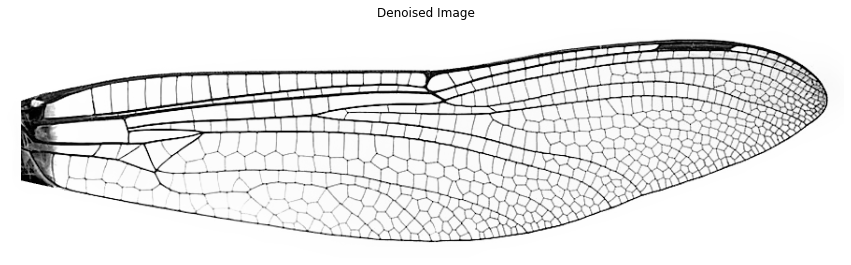

In [4]:
# Denoise
img_denoise = denoise_bilateral(img, sigma_color=0.05, sigma_spatial=15)

# Plot
plt.figure(figsize=(15, 10))
plt.imshow(img_denoise, cmap='gray')
plt.title("Denoised Image")
plt.axis('off')
plt.show()

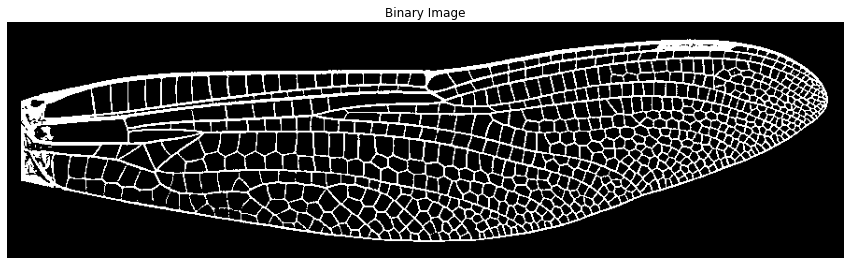

In [26]:
# Convert to binary image
local_thresh = threshold_local(img_denoise, block_size=35, offset=.001)
img_binary = img_denoise < local_thresh

# Plot
plt.figure(figsize=(15, 10))
plt.imshow(img_binary, cmap='gray')
plt.title("Binary Image")
plt.axis('off')
plt.show()

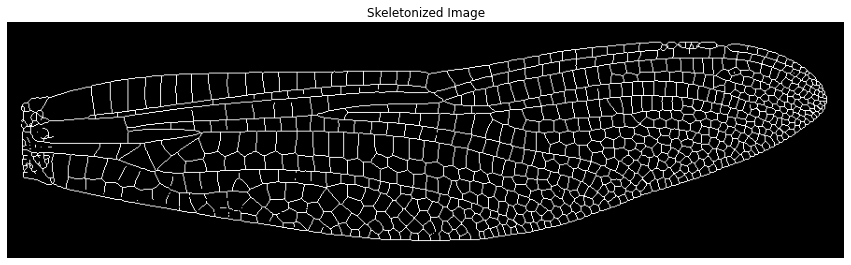

In [27]:
# Skeletonize the Binary Vein Structure
img_skeleton = skeletonize(img_binary)

# Plot
plt.figure(figsize=(15, 10))
plt.imshow(img_skeleton, cmap='gray')
plt.title('Skeletonized Image')
plt.axis('off')
plt.show()

Number of foreground points (vein pixels): 17614


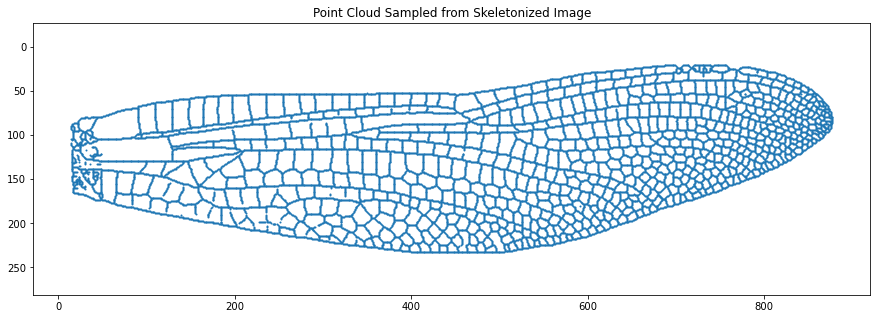

In [28]:
## Get point cloud: from skeleton image
# Get coordinates of all foreground pixels (vein areas)
points = np.column_stack(np.nonzero(img_skeleton))  # shape: (N, 2)

# Count how many points
num_points = len(points)
print(f"Number of foreground points (vein pixels): {num_points}")

# Plot
plt.figure(figsize=(15, 5))
plt.scatter(points[:, 1], points[:, 0], s=1)
plt.gca().invert_yaxis()
plt.title("Point Cloud Sampled from Skeletonized Image")
plt.axis('equal')
plt.show()

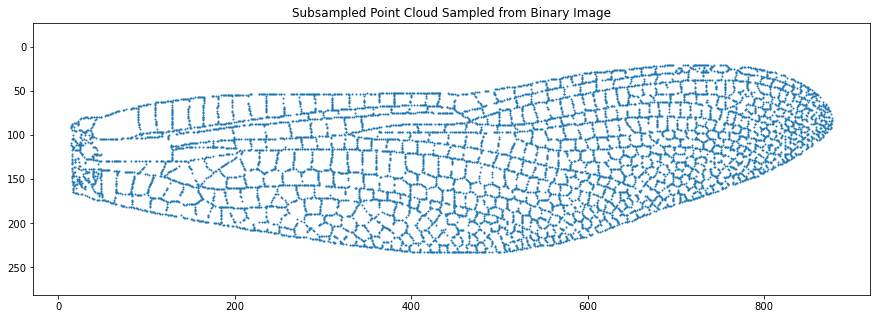

In [29]:
# Randomly subsample
n_sample = 10000
if len(points) > n_sample:
    idx = np.random.choice(len(points), size=n_sample, replace=False)
    points_sampled = points[idx]
else:
    points_sampled = points

# Plot
plt.figure(figsize=(15, 5))
plt.scatter(points_sampled[:, 1], points_sampled[:, 0], s=1)
plt.gca().invert_yaxis()
plt.title("Subsampled Point Cloud Sampled from Binary Image")
plt.axis('equal')
plt.show()

## Topological data analysis (TDA)

In [30]:
from ripser import ripser
from persim import plot_diagrams
import time

In [31]:
## Subsampled points
# Rips filtration
start_time = time.time()
result = ripser(points_sampled, maxdim=1)  # H0 and H1
diagrams = result["dgms"]
end_time = time.time()

# Print runtime
runtime = end_time - start_time
print(f"Persistent homology computation took {runtime:.2f} seconds.")

Persistent homology computation took 67.41 seconds.


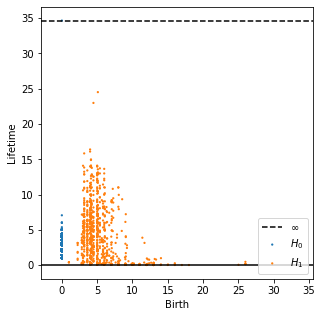

In [32]:
# Plot persistent diagram
plt.figure(figsize=(5, 5))
plot_diagrams(diagrams, show=True, lifetime=True, size=5)

In [31]:
## Full sampling points
# Rips filtration
start_time = time.time()
result_full = ripser(points, maxdim=1)  # H0 and H1
diagrams_full = result_full["dgms"]
end_time = time.time()

# Print runtime
runtime = end_time - start_time
print(f"Persistent homology computation took {runtime:.2f} seconds.") # 47mins

Persistent homology computation took 2807.62 seconds.


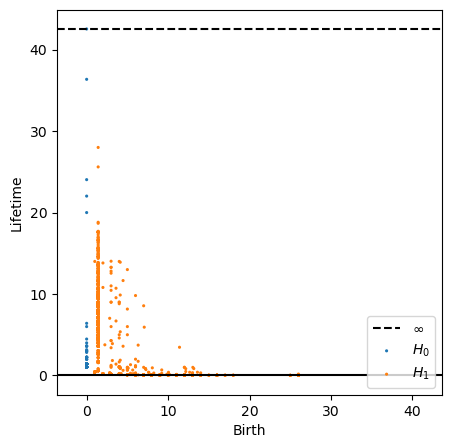

In [33]:
# Plot persistent diagram
plt.figure(figsize=(5, 5))
plot_diagrams(diagrams_full, show=True, lifetime=True, size=5)

## Applying the workflow to other insect wings

In [74]:
# Image processing function
def img_proc(img_path, block_size, offset, n_sample):
    # Load grayscale image
    img = io.imread(img_path, as_gray=True)

    # Denoise
    img_denoise = denoise_bilateral(img, sigma_color=0.05, sigma_spatial=15)

    # Convert to binary image
    local_thresh = threshold_local(img_denoise, block_size=block_size, offset=offset)
    img_binary = img_denoise < local_thresh

    # Skeletonize the Binary Vein Structure
    img_skeleton = skeletonize(img_binary)

    # Get coordinates of all foreground pixels (vein areas)
    points = np.column_stack(np.nonzero(img_skeleton))  # shape: (N, 2)
    num_points = len(points)
    print(f"Number of foreground points (vein pixels): {num_points}")
    
    # subsampling
    if len(points) > n_sample:
        idx = np.random.choice(len(points), size=n_sample, replace=False)
        points_sampled = points[idx]
    else:
        points_sampled = points
    
    # plot
    fig, ax = plt.subplots(2, 3, figsize=(7, 6))

    ax[0,0].imshow(img, cmap='gray')
    ax[0,0].set_title('Grayscale Original Image')
    ax[0,0].axis('off')

    ax[0,1].imshow(img_denoise, cmap='gray')
    ax[0,1].set_title('Denoised Image')
    ax[0,1].axis('off')

    ax[0,2].imshow(img_binary, cmap='gray')
    ax[0,2].set_title('Binary Image')
    ax[0,2].axis('off')

    ax[1,0].imshow(img_skeleton, cmap='gray')
    ax[1,0].set_title('Skeletonized Image')
    ax[1,0].axis('off')

    ax[1,1].scatter(points[:, 1], points[:, 0], s=.05)
    ax[1,1].invert_yaxis()
    ax[1,1].set_title('Point Cloud')
    ax[1,1].axis('off')
    ax[1,1].set_aspect(1.0)
    
    ax[1,2].scatter(points_sampled[:, 1], points_sampled[:, 0], s=.05)
    ax[1,2].invert_yaxis()
    ax[1,2].set_title('Subsampled Point Cloud')
    ax[1,2].axis('off')
    ax[1,2].set_aspect(1.0)

    plt.tight_layout()
    plt.show()
    
    return points_sampled

In [39]:
# TDA function
def run_TDA(points):
    global result
    # Rips filtration
    start_time = time.time()
    result = ripser(points, maxdim=1)  # H0 and H1
    diagrams = result["dgms"]
    end_time = time.time()

    # Print runtime
    runtime = end_time - start_time
    print(f"Persistent homology computation took {runtime:.2f} seconds.")
    
    # Plot persistent diagram
    plt.figure(figsize=(5, 5))
    plot_diagrams(diagrams, show=True, lifetime=True, size=5)

Number of foreground points (vein pixels): 17551


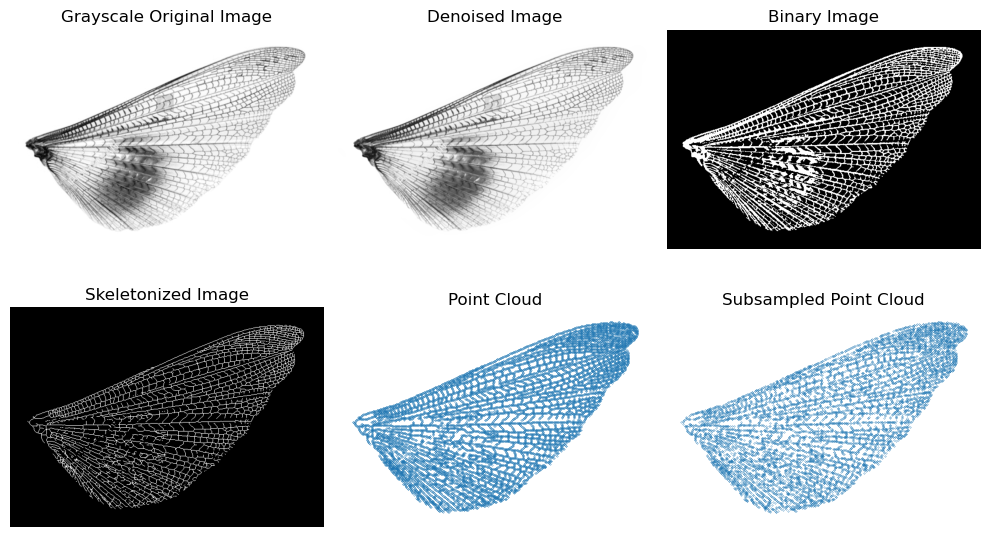

In [68]:
# Grasshopper
points_sampled = img_proc('wing_grasshopper.jpg', 35, 0.001, 10000)

Persistent homology computation took 54.78 seconds.


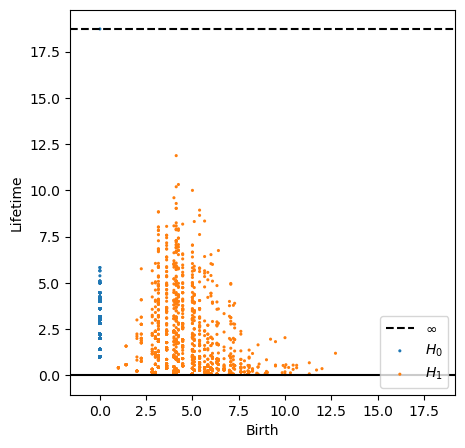

In [69]:
# Grasshopper
run_TDA(points_sampled)

Number of foreground points (vein pixels): 3488


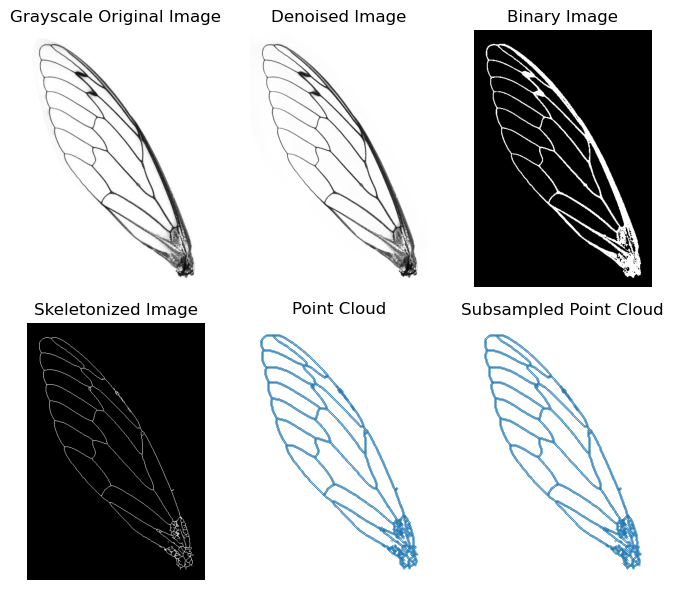

In [75]:
# Cicada
points_sampled = img_proc('wing_cicada.jpg', 101, 0.01, 10000)

Persistent homology computation took 41.43 seconds.


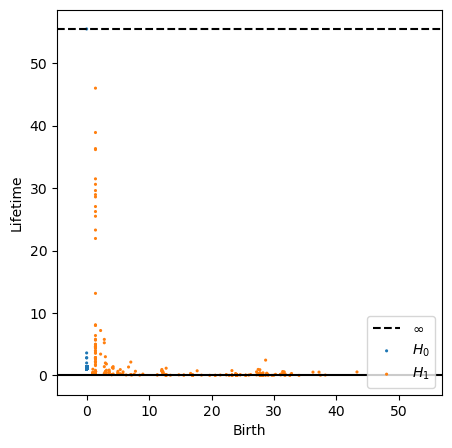

In [73]:
# Cicada
run_TDA(points_sampled)